## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [11]:
%pip install pytorch-lightning

In [12]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, Flowers102

import matplotlib.pyplot as plt
import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [13]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
class FlowersDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, image_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            # normalize to [-1, 1] for GANs
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5)),
        ])

    def prepare_data(self):
        Flowers102(self.data_dir, split="train", download=True)
        Flowers102(self.data_dir, split="val", download=True)
        Flowers102(self.data_dir, split="test", download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.flowers_train = Flowers102(self.data_dir, split="train",
                                            transform=self.transform)
            self.flowers_val = Flowers102(self.data_dir, split="val",
                                          transform=self.transform)

        if stage == "test" or stage is None:
            self.flowers_test = Flowers102(self.data_dir, split="test",
                                           transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.flowers_train, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.flowers_val, batch_size=self.batch_size,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.flowers_test, batch_size=self.batch_size,
                          num_workers=self.num_workers)

In [14]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [15]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=1):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, channels, kernel_size=7)  # [n, c, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [22]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        
        # Required for multiple optimizers
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        opt_g, opt_d = self.optimizers()
        
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Train Generator
        opt_g.zero_grad()
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)

        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)
        
        self.manual_backward(g_loss)
        opt_g.step()

        # Train Discriminator
        opt_d.zero_grad()
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1)
        y_real = y_real.type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(self(z).detach())
        y_fake = torch.zeros(real_imgs.size(0), 1)
        y_fake = y_fake.type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()
        
        log_dict = {'g_loss': g_loss, 'd_loss': d_loss}
        return {'loss': g_loss + d_loss, 'progress_bar': log_dict, "log": log_dict}
            

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        e = self.current_epoch
        is_power_of_2 = (e > 0 and (e & (e - 1)) == 0)
        show = is_power_of_2 or e == 0 or e == self.trainer.max_epochs - 1
        self.plot_imgs(show=show)
    
    def plot_imgs(self, show=False):
        if not show:
            return
        
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        fig = plt.figure(facecolor='black')
        fig.patch.set_facecolor('black')
        for i in range(sample_imgs.shape[0]):
            ax = plt.subplot(2, 4, i+1)
            ax.set_facecolor('black')
            plt.tight_layout()
            # Invert colors: change from gray_r to gray (or use 1 - image)
            plt.imshow(sample_imgs.detach()[i, 0, :, :].reshape(28, 28), cmap='gray', interpolation='none')
            plt.title('Epoch {}'.format(self.current_epoch), color='white')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

        plt.show()
        plt.close(fig)

In [23]:
dm = MNISTDataModule()
model = GAN()

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  358 K │ train │     0 │
│ 1 │ discriminator │ Discriminator │ 21.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 379 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 379 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

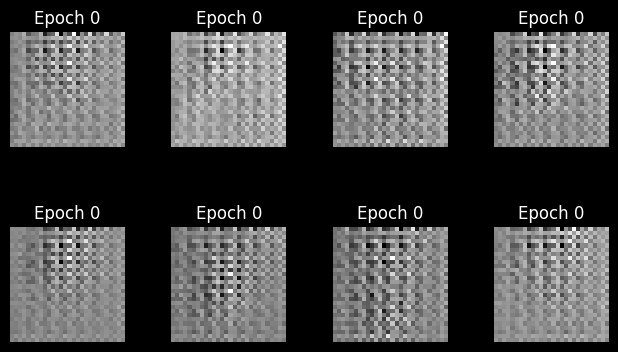

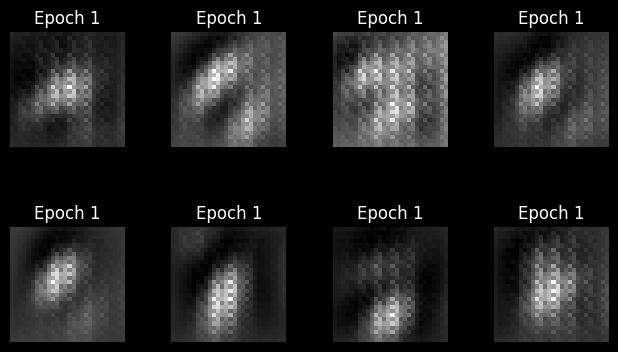

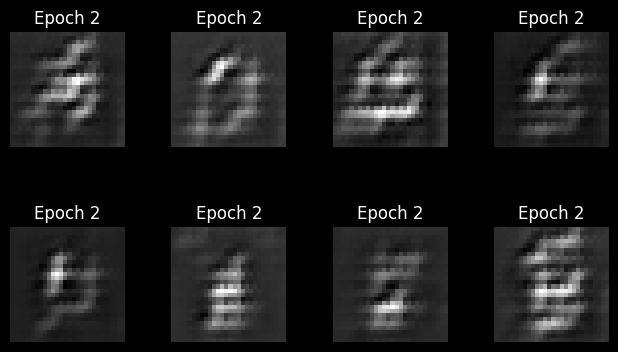

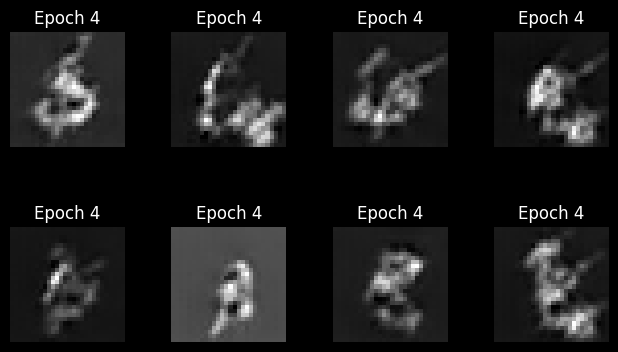

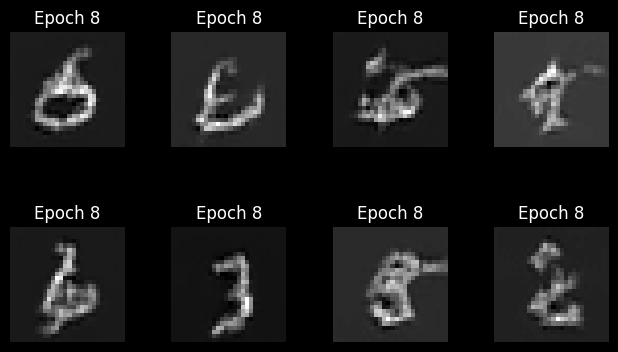

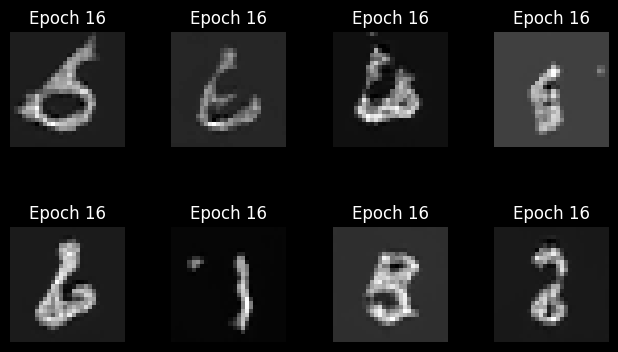

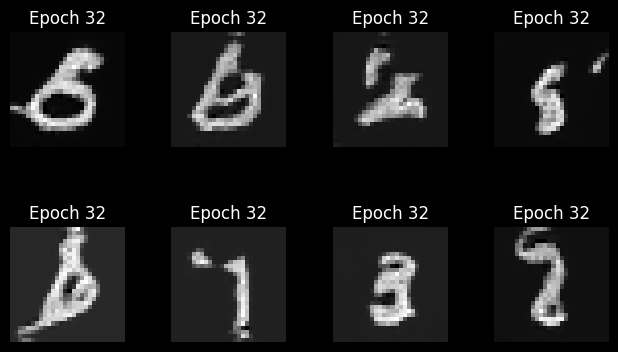

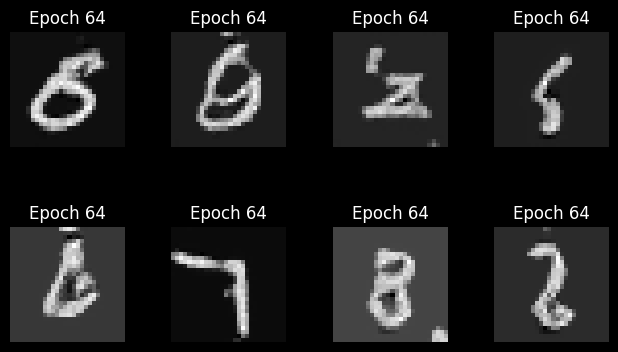

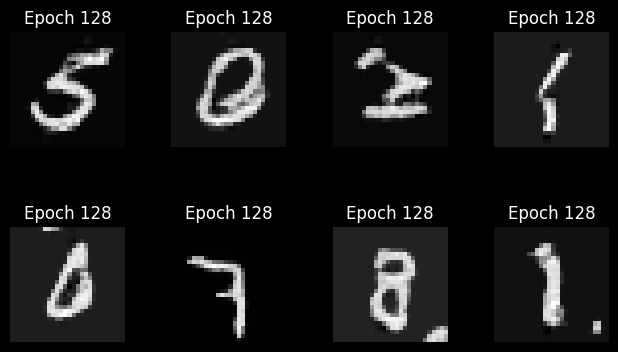

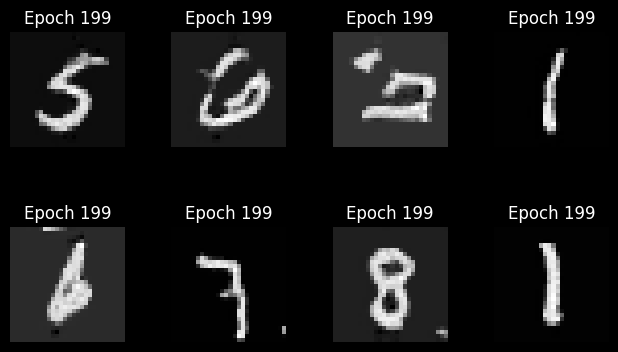

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [24]:
trainer = pl.Trainer(max_epochs=200, devices=AVAIL_GPUS)
trainer.fit(model, dm)